<a href="https://colab.research.google.com/github/perrin1/Blog_app/blob/main/Algorithme_DBSCAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# ============================================================================
# DBSCAN - Implémentation Complète en Python
# Density-Based Spatial Clustering of Applications with Noise
# ============================================================================

# Importation des bibliothèques nécessaires
import numpy as np                    # Pour les calculs numériques et les tableaux
import matplotlib.pyplot as plt       # Pour la visualisation des données
import seaborn as sns                # Pour des graphiques plus esthétiques
from sklearn.datasets import make_blobs, make_circles, make_moons  # Générateurs de données
from sklearn.preprocessing import StandardScaler  # Pour la normalisation
from sklearn.cluster import DBSCAN as DBSCAN_sklearn  # Pour comparaison
from collections import deque        # Pour la file d'attente dans l'algorithme
import warnings
warnings.filterwarnings('ignore')   # Ignorer les avertissements pour la clarté

# Configuration des graphiques
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


In [7]:
# ============================================================================
# CLASSE DBSCAN - IMPLÉMENTATION FROM SCRATCH
# ============================================================================


In [8]:
class DBSCAN:
    """
    Implémentation de l'algorithme DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

    Paramètres:
    -----------
    eps : float
        Distance maximale entre deux échantillons pour qu'ils soient considérés comme voisins
    min_samples : int
        Nombre minimum d'échantillons dans un voisinage pour qu'un point soit considéré comme core
    """

    def __init__(self, eps=0.5, min_samples=5):
        """
        Initialisation des paramètres de l'algorithme

        Args:
            eps (float): Rayon epsilon pour définir le voisinage
            min_samples (int): Nombre minimum de points pour former un cluster
        """
        self.eps = eps                    # Stockage du paramètre epsilon
        self.min_samples = min_samples    # Stockage du nombre minimum de points
        self.labels_ = None               # Étiquettes des clusters (sera rempli après fit)
        self.core_sample_indices_ = None  # Indices des points core

    def _get_neighbors(self, X, point_idx):
        """
        Trouve tous les voisins d'un point dans un rayon eps

        Args:
            X (array): Dataset des points
            point_idx (int): Index du point pour lequel on cherche les voisins

        Returns:
            list: Liste des indices des points voisins
        """
        # Calcul de la distance euclidienne entre le point et tous les autres points
        distances = np.sqrt(np.sum((X - X[point_idx]) ** 2, axis=1))

        # Retourne les indices des points dont la distance est <= eps
        return np.where(distances <= self.eps)[0].tolist()

    def _expand_cluster(self, X, point_idx, neighbors, cluster_id, labels, visited):
        """
        Étend un cluster en ajoutant tous les points densité-connectés

        Args:
            X (array): Dataset des points
            point_idx (int): Index du point core à partir duquel étendre
            neighbors (list): Liste des voisins du point core
            cluster_id (int): ID du cluster en cours de construction
            labels (array): Tableau des étiquettes (modifié en place)
            visited (array): Tableau des points visités (modifié en place)
        """
        # Assigner le point core au cluster
        labels[point_idx] = cluster_id

        # Utiliser une file d'attente pour parcourir tous les points à examiner
        seed_set = deque(neighbors)  # File d'attente initialisée avec les voisins

        # Tant qu'il y a des points à examiner dans la file
        while seed_set:
            current_point = seed_set.popleft()  # Prendre le premier point de la file

            # Si le point n'a pas été visité
            if not visited[current_point]:
                visited[current_point] = True  # Marquer comme visité

                # Trouver les voisins de ce point
                current_neighbors = self._get_neighbors(X, current_point)

                # Si ce point a suffisamment de voisins (c'est un point core)
                if len(current_neighbors) >= self.min_samples:
                    # Ajouter ses nouveaux voisins à la file d'attente
                    for neighbor in current_neighbors:
                        if neighbor not in seed_set:
                            seed_set.append(neighbor)

            # Si le point n'appartient à aucun cluster, l'assigner au cluster actuel
            if labels[current_point] == -1:  # -1 indique un point non assigné
                labels[current_point] = cluster_id

    def fit(self, X):
        """
        Applique l'algorithme DBSCAN sur les données

        Args:
            X (array): Dataset de forme (n_samples, n_features)

        Returns:
            self: Retourne l'instance pour permettre le chaînage de méthodes
        """
        n_points = len(X)  # Nombre total de points dans le dataset

        # Initialisation des structures de données
        labels = np.full(n_points, -1)      # -1 = non assigné, 0+ = cluster ID
        visited = np.zeros(n_points, dtype=bool)  # False = non visité
        cluster_id = 0                      # Compteur pour les IDs de clusters
        core_samples = []                   # Liste des indices des points core

        # Parcourir chaque point dans le dataset
        for point_idx in range(n_points):
            # Si le point a déjà été visité, passer au suivant
            if visited[point_idx]:
                continue

            # Marquer le point comme visité
            visited[point_idx] = True

            # Trouver tous les voisins de ce point
            neighbors = self._get_neighbors(X, point_idx)

            # Si le point n'a pas assez de voisins, il reste un point de bruit
            if len(neighbors) < self.min_samples:
                labels[point_idx] = -1  # Marquer comme bruit (outlier)
            else:
                # Le point est un core point
                core_samples.append(point_idx)

                # Créer un nouveau cluster et l'étendre
                self._expand_cluster(X, point_idx, neighbors, cluster_id, labels, visited)

                # Incrémenter l'ID pour le prochain cluster
                cluster_id += 1

        # Stocker les résultats dans l'instance
        self.labels_ = labels
        self.core_sample_indices_ = np.array(core_samples)

        return self

    def fit_predict(self, X):
        """
        Applique DBSCAN et retourne les étiquettes des clusters

        Args:
            X (array): Dataset de forme (n_samples, n_features)

        Returns:
            array: Étiquettes des clusters pour chaque point
        """
        self.fit(X)        # Appliquer l'algorithme
        return self.labels_  # Retourner les étiquettes


In [9]:
# ============================================================================
# FONCTIONS UTILITAIRES POUR LA VISUALISATION ET L'ANALYSE
# ============================================================================

In [10]:
def plot_dbscan_results(X, labels, title="Résultats DBSCAN", eps=None, min_samples=None):
    """
    Visualise les résultats du clustering DBSCAN

    Args:
        X (array): Points de données
        labels (array): Étiquettes des clusters
        title (str): Titre du graphique
        eps (float): Paramètre epsilon utilisé
        min_samples (int): Paramètre min_samples utilisé
    """
    # Créer une nouvelle figure
    plt.figure(figsize=(10, 8))

    # Obtenir les clusters uniques
    unique_labels = set(labels)
    # Générer une couleur pour chaque cluster
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

    # Pour chaque cluster
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Points de bruit en noir
            col = 'black'
            marker = 'x'
            label = 'Bruit'
            size = 50
        else:
            # Points du cluster avec une couleur spécifique
            marker = 'o'
            label = f'Cluster {k}'
            size = 60

        # Sélectionner les points appartenant à ce cluster
        class_member_mask = (labels == k)
        xy = X[class_member_mask]

        # Tracer les points
        plt.scatter(xy[:, 0], xy[:, 1], c=[col], marker=marker,
                   s=size, alpha=0.7, label=label, edgecolors='black', linewidth=0.5)

    # Configuration du graphique
    plt.title(f'{title}\n(eps={eps}, min_samples={min_samples})', fontsize=14, fontweight='bold')
    plt.xlabel('Dimension 1', fontsize=12)
    plt.ylabel('Dimension 2', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


In [11]:
def analyze_clusters(labels):
    """
    Analyse et affiche les statistiques des clusters trouvés

    Args:
        labels (array): Étiquettes des clusters
    """
    unique_labels = set(labels)
    n_clusters = len(unique_labels) - (1 if -1 in labels else 0)  # Exclure le bruit
    n_noise = list(labels).count(-1)  # Compter les points de bruit

    print("="*50)
    print("ANALYSE DES CLUSTERS")
    print("="*50)
    print(f"Nombre de clusters trouvés: {n_clusters}")
    print(f"Nombre de points de bruit: {n_noise}")
    print(f"Total de points: {len(labels)}")

    # Statistiques par cluster
    if n_clusters > 0:
        print("\nTaille de chaque cluster:")
        for label in unique_labels:
            if label != -1:
                size = list(labels).count(label)
                percentage = (size / len(labels)) * 100
                print(f"  Cluster {label}: {size} points ({percentage:.1f}%)")


In [12]:
def plot_parameter_analysis(X, eps_values, min_samples_values):
    """
    Analyse l'effet des différents paramètres sur le clustering

    Args:
        X (array): Dataset
        eps_values (list): Valeurs d'epsilon à tester
        min_samples_values (list): Valeurs de min_samples à tester
    """
    fig, axes = plt.subplots(len(eps_values), len(min_samples_values),
                            figsize=(4*len(min_samples_values), 4*len(eps_values)))

    # Si on n'a qu'une ligne ou colonne, s'assurer que axes est un tableau 2D
    if len(eps_values) == 1:
        axes = axes.reshape(1, -1)
    if len(min_samples_values) == 1:
        axes = axes.reshape(-1, 1)

    for i, eps in enumerate(eps_values):
        for j, min_samples in enumerate(min_samples_values):
            # Appliquer DBSCAN avec ces paramètres
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(X)

            # Calculer les statistiques
            unique_labels = set(labels)
            n_clusters = len(unique_labels) - (1 if -1 in labels else 0)
            n_noise = list(labels).count(-1)

            # Tracer les résultats
            ax = axes[i, j]

            # Couleurs pour les clusters
            colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

            for k, col in zip(unique_labels, colors):
                if k == -1:
                    col = 'black'
                    marker = 'x'
                    size = 30
                else:
                    marker = 'o'
                    size = 40

                class_member_mask = (labels == k)
                xy = X[class_member_mask]
                ax.scatter(xy[:, 0], xy[:, 1], c=[col], marker=marker, s=size, alpha=0.7)

            ax.set_title(f'eps={eps}, min_samples={min_samples}\n'
                        f'Clusters: {n_clusters}, Bruit: {n_noise}', fontsize=10)
            ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


In [13]:
# ============================================================================
# GÉNÉRATION DE DATASETS DE TEST
# ============================================================================

def generate_test_datasets():
    """
    Génère différents types de datasets pour tester DBSCAN

    Returns:
        dict: Dictionnaire contenant les datasets
    """
    datasets = {}

    # Dataset 1: Blobs simples (clusters sphériques)
    X1, y1 = make_blobs(n_samples=300, centers=4, n_features=2,
                        random_state=42, cluster_std=0.8)
    datasets['blobs'] = X1

    # Dataset 2: Cercles concentriques
    X2, y2 = make_circles(n_samples=300, noise=0.1, factor=0.5, random_state=42)
    datasets['circles'] = X2

    # Dataset 3: Deux lunes entrelacées
    X3, y3 = make_moons(n_samples=300, noise=0.1, random_state=42)
    datasets['moons'] = X3

    # Dataset 4: Dataset avec du bruit
    np.random.seed(42)
    # Créer des clusters principaux
    cluster1 = np.random.normal([2, 2], 0.5, (100, 2))
    cluster2 = np.random.normal([8, 8], 0.5, (100, 2))
    cluster3 = np.random.normal([2, 8], 0.5, (80, 2))
    # Ajouter du bruit
    noise = np.random.uniform(0, 10, (50, 2))
    X4 = np.vstack([cluster1, cluster2, cluster3, noise])
    datasets['noisy'] = X4

    return datasets


In [14]:
# ============================================================================
# FONCTION POUR DÉTERMINER LES PARAMÈTRES OPTIMAUX
# ============================================================================

def find_optimal_eps(X, k=4):
    """
    Utilise la méthode du k-distance pour trouver epsilon optimal

    Args:
        X (array): Dataset
        k (int): Nombre de plus proches voisins à considérer

    Returns:
        float: Valeur d'epsilon suggérée
    """
    from sklearn.neighbors import NearestNeighbors

    # Calculer les k plus proches voisins
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(X)
    distances, indices = neighbors_fit.kneighbors(X)

    # Prendre la distance au k-ème voisin et trier
    k_distances = distances[:, k-1]
    k_distances = np.sort(k_distances)[::-1]

    # Tracer le graphique k-distance
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(k_distances)), k_distances, 'b-', linewidth=2)
    plt.xlabel('Points triés par distance')
    plt.ylabel(f'Distance au {k}-ème plus proche voisin')
    plt.title(f'Graphique K-Distance (k={k})\nChercher le "coude" pour déterminer epsilon')
    plt.grid(True, alpha=0.3)

    # Ajouter une ligne horizontale pour aider à identifier le coude
    # Suggestion: utiliser le percentile 95 comme point de départ
    suggested_eps = np.percentile(k_distances, 95)
    plt.axhline(y=suggested_eps, color='red', linestyle='--',
                label=f'Epsilon suggéré: {suggested_eps:.3f}')
    plt.legend()
    plt.show()

    return suggested_eps


In [15]:
# ============================================================================
# DÉMONSTRATION COMPLÈTE
# ============================================================================

def main_demonstration():
    """
    Fonction principale pour démontrer l'implémentation DBSCAN
    """
    print("="*80)
    print("DÉMONSTRATION DE L'ALGORITHME DBSCAN")
    print("Implémentation from scratch avec explications détaillées")
    print("="*80)

    # Générer les datasets de test
    print("\n1. GÉNÉRATION DES DATASETS DE TEST")
    print("-" * 40)
    datasets = generate_test_datasets()

    # Visualiser les datasets bruts
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()

    for idx, (name, X) in enumerate(datasets.items()):
        axes[idx].scatter(X[:, 0], X[:, 1], c='blue', alpha=0.6, s=50)
        axes[idx].set_title(f'Dataset: {name.capitalize()}', fontsize=14, fontweight='bold')
        axes[idx].grid(True, alpha=0.3)
        axes[idx].set_xlabel('Dimension 1')
        axes[idx].set_ylabel('Dimension 2')

    plt.tight_layout()
    plt.show()

    # Test sur le dataset "blobs"
    print("\n2. ANALYSE DU DATASET 'BLOBS'")
    print("-" * 40)
    X = datasets['blobs']

    # Normaliser les données
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Trouver epsilon optimal
    print("Détermination de l'epsilon optimal...")
    optimal_eps = find_optimal_eps(X_scaled, k=4)
    print(f"Epsilon suggéré: {optimal_eps:.3f}")

    # Appliquer notre implémentation DBSCAN
    print("\nApplication de notre implémentation DBSCAN...")
    dbscan_custom = DBSCAN(eps=0.3, min_samples=5)
    labels_custom = dbscan_custom.fit_predict(X_scaled)

    # Analyser les résultats
    analyze_clusters(labels_custom)

    # Visualiser les résultats
    plot_dbscan_results(X_scaled, labels_custom,
                       "Notre implémentation DBSCAN - Dataset Blobs",
                       eps=0.3, min_samples=5)

    # Comparaison avec sklearn
    print("\n3. COMPARAISON AVEC L'IMPLÉMENTATION SKLEARN")
    print("-" * 50)
    dbscan_sklearn = DBSCAN_sklearn(eps=0.3, min_samples=5)
    labels_sklearn = dbscan_sklearn.fit_predict(X_scaled)

    # Vérifier si les résultats sont identiques
    are_identical = np.array_equal(labels_custom, labels_sklearn)
    print(f"Résultats identiques à sklearn: {are_identical}")

    if not are_identical:
        print("Note: De légères différences peuvent exister due à l'ordre de traitement des points")

    # Visualiser la comparaison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Notre implémentation
    unique_labels = set(labels_custom)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = 'black'
            marker = 'x'
        else:
            marker = 'o'

        class_member_mask = (labels_custom == k)
        xy = X_scaled[class_member_mask]
        ax1.scatter(xy[:, 0], xy[:, 1], c=[col], marker=marker, s=60, alpha=0.7)

    ax1.set_title('Notre implémentation', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)

    # Implémentation sklearn
    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = 'black'
            marker = 'x'
        else:
            marker = 'o'

        class_member_mask = (labels_sklearn == k)
        xy = X_scaled[class_member_mask]
        ax2.scatter(xy[:, 0], xy[:, 1], c=[col], marker=marker, s=60, alpha=0.7)

    ax2.set_title('Implémentation Sklearn', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Test sur différents datasets
    print("\n4. TEST SUR DIFFÉRENTS TYPES DE DATASETS")
    print("-" * 45)

    for name, X in datasets.items():
        print(f"\nDataset: {name.upper()}")
        print("-" * 30)

        # Normaliser
        X_scaled = scaler.fit_transform(X)

        # Paramètres adaptés selon le dataset
        if name == 'circles':
            eps, min_samples = 0.3, 5
        elif name == 'moons':
            eps, min_samples = 0.3, 5
        elif name == 'noisy':
            eps, min_samples = 0.4, 8
        else:
            eps, min_samples = 0.3, 5

        # Appliquer DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_scaled)

        # Analyser et visualiser
        analyze_clusters(labels)
        plot_dbscan_results(X_scaled, labels,
                           f"DBSCAN - Dataset {name.capitalize()}",
                           eps=eps, min_samples=min_samples)

    # Analyse de sensibilité des paramètres
    print("\n5. ANALYSE DE SENSIBILITÉ DES PARAMÈTRES")
    print("-" * 45)

    X_test = datasets['moons']
    X_test_scaled = scaler.fit_transform(X_test)

    eps_values = [0.1, 0.2, 0.3]
    min_samples_values = [3, 5, 8]

    print("Test de différentes combinaisons de paramètres...")
    plot_parameter_analysis(X_test_scaled, eps_values, min_samples_values)

    print("\n" + "="*80)
    print("DÉMONSTRATION TERMINÉE")
    print("L'implémentation DBSCAN est fonctionnelle et a été testée avec succès!")
    print("="*80)


In [16]:
# ============================================================================
# EXEMPLE D'UTILISATION SIMPLE
# ============================================================================

def simple_example():
    """
    Exemple simple d'utilisation de notre implémentation DBSCAN
    """
    print("EXEMPLE SIMPLE D'UTILISATION")
    print("="*40)

    # Créer des données d'exemple simples
    np.random.seed(42)
    # Trois groupes de points
    group1 = np.random.normal([0, 0], 0.5, (50, 2))
    group2 = np.random.normal([3, 3], 0.5, (50, 2))
    group3 = np.random.normal([0, 3], 0.5, (40, 2))
    # Quelques points de bruit
    noise = np.random.uniform(-1, 4, (20, 2))

    # Combiner toutes les données
    X = np.vstack([group1, group2, group3, noise])

    print(f"Dataset créé avec {len(X)} points")

    # Appliquer DBSCAN
    dbscan = DBSCAN(eps=0.8, min_samples=5)
    labels = dbscan.fit_predict(X)

    # Afficher les résultats
    analyze_clusters(labels)
    plot_dbscan_results(X, labels, "Exemple Simple DBSCAN", eps=0.8, min_samples=5)

    return X, labels


Choisissez le type de démonstration:
1. Exemple simple
2. Démonstration complète

Exécution de l'exemple simple...

EXEMPLE SIMPLE D'UTILISATION
Dataset créé avec 160 points
ANALYSE DES CLUSTERS
Nombre de clusters trouvés: 3
Nombre de points de bruit: 7
Total de points: 160

Taille de chaque cluster:
  Cluster 0: 54 points (33.8%)
  Cluster 1: 55 points (34.4%)
  Cluster 2: 44 points (27.5%)


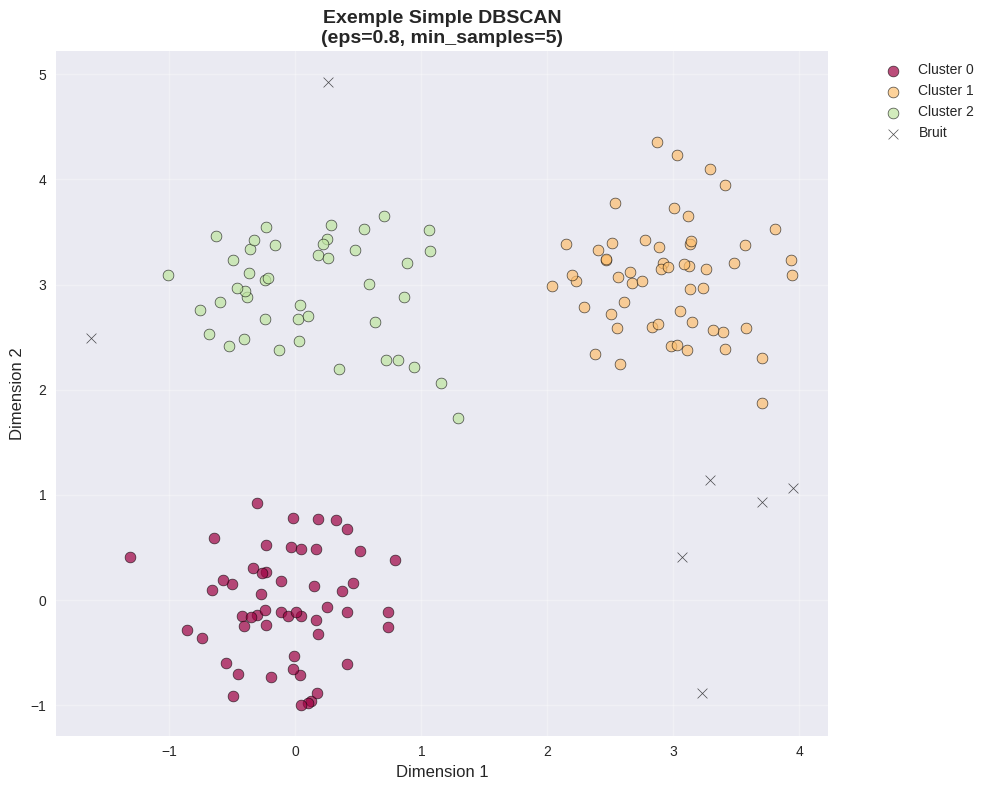


Pour une démonstration complète, décommentez la ligne suivante:
# main_demonstration()
DÉMONSTRATION DE L'ALGORITHME DBSCAN
Implémentation from scratch avec explications détaillées

1. GÉNÉRATION DES DATASETS DE TEST
----------------------------------------


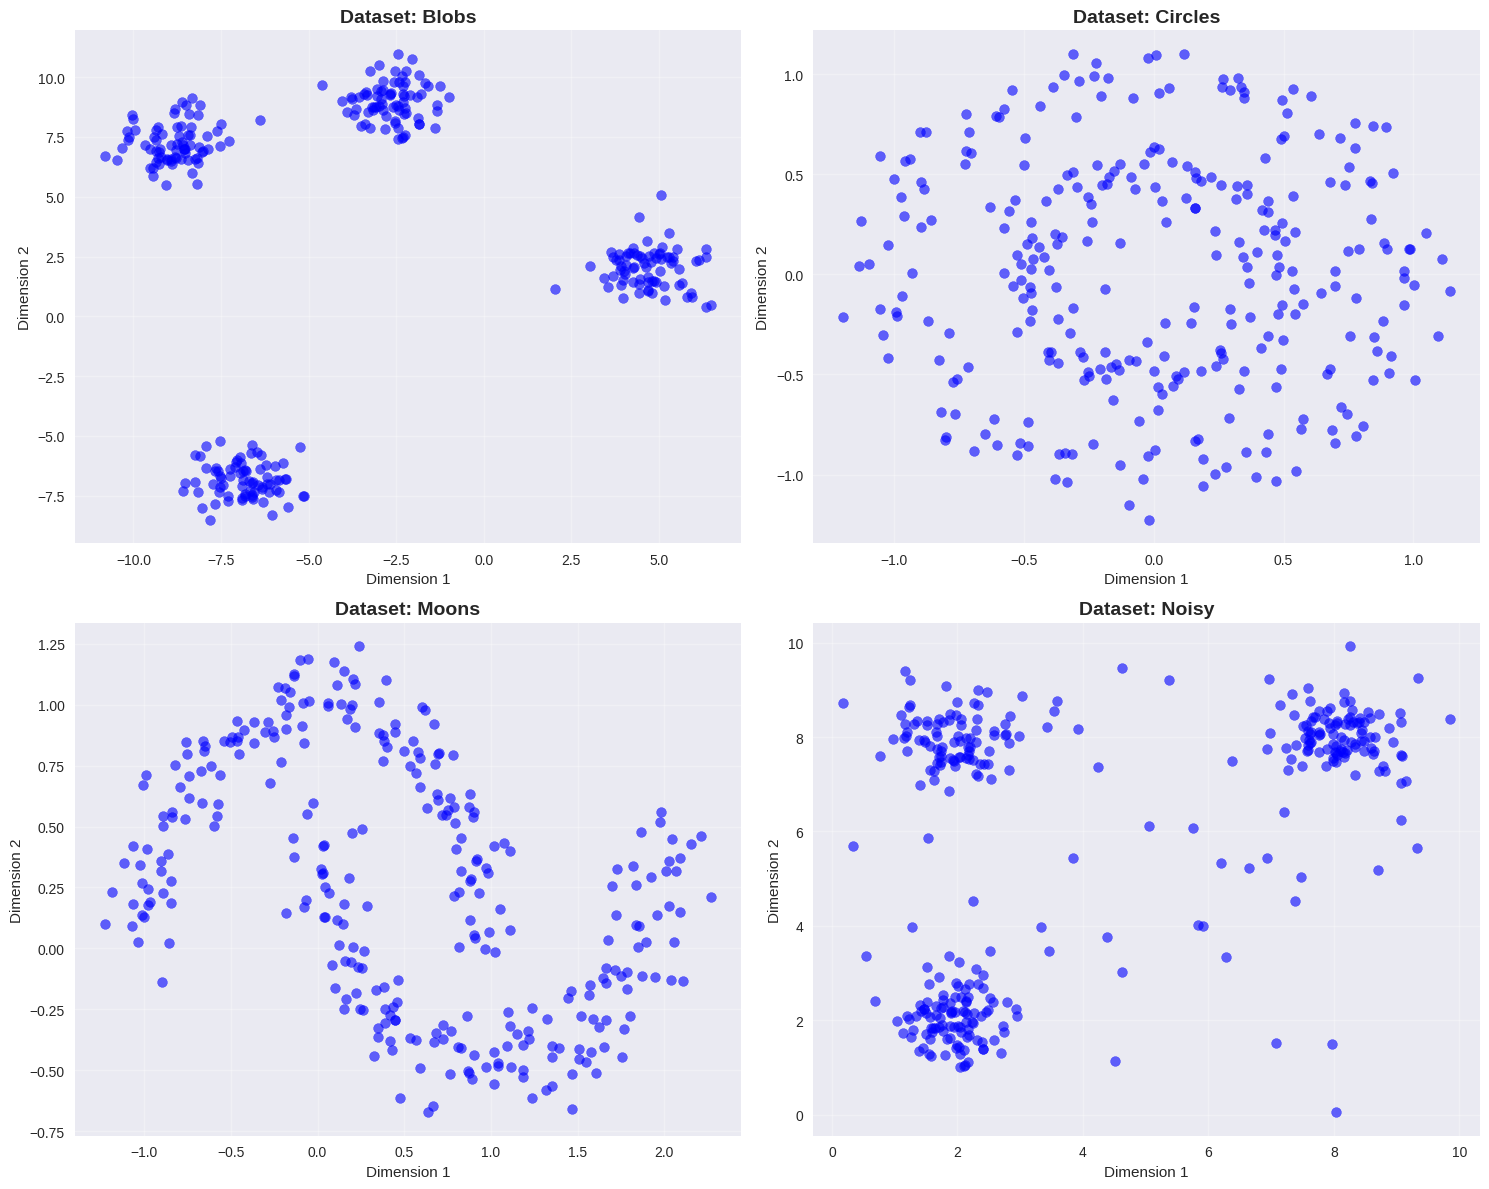


2. ANALYSE DU DATASET 'BLOBS'
----------------------------------------
Détermination de l'epsilon optimal...


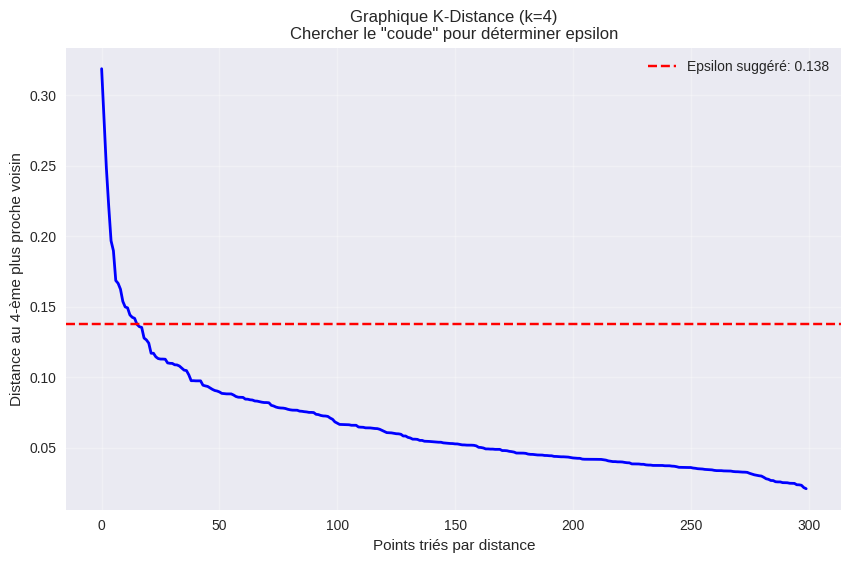

Epsilon suggéré: 0.138

Application de notre implémentation DBSCAN...
ANALYSE DES CLUSTERS
Nombre de clusters trouvés: 4
Nombre de points de bruit: 0
Total de points: 300

Taille de chaque cluster:
  Cluster 0: 75 points (25.0%)
  Cluster 1: 75 points (25.0%)
  Cluster 2: 75 points (25.0%)
  Cluster 3: 75 points (25.0%)


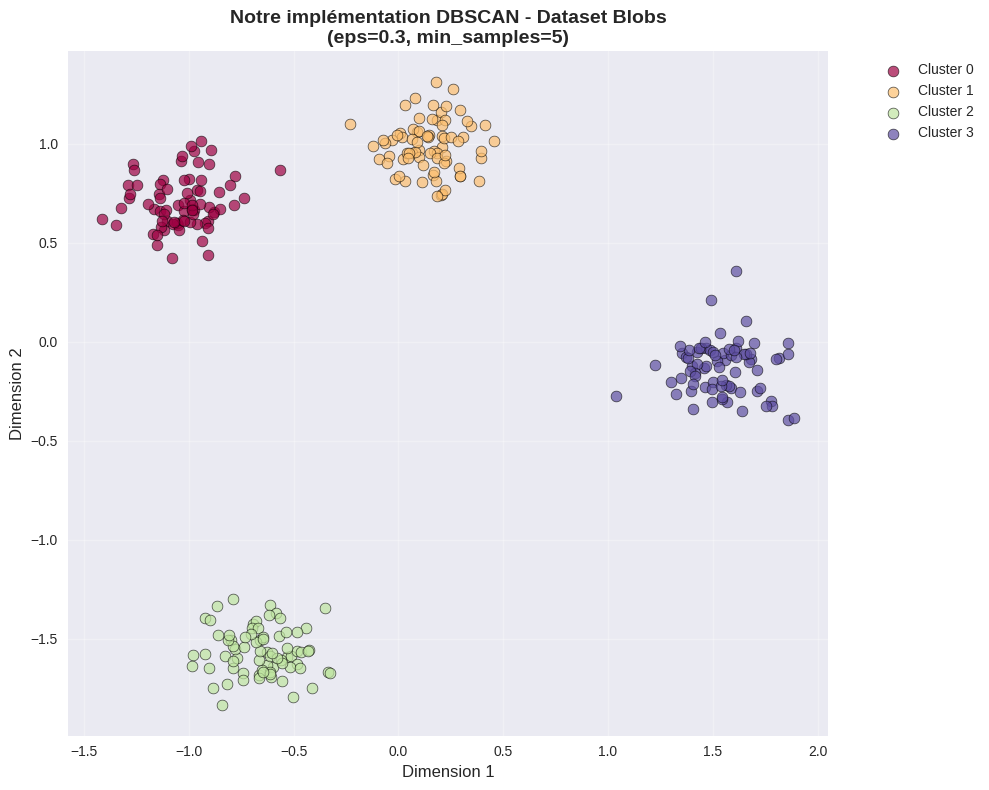


3. COMPARAISON AVEC L'IMPLÉMENTATION SKLEARN
--------------------------------------------------
Résultats identiques à sklearn: True


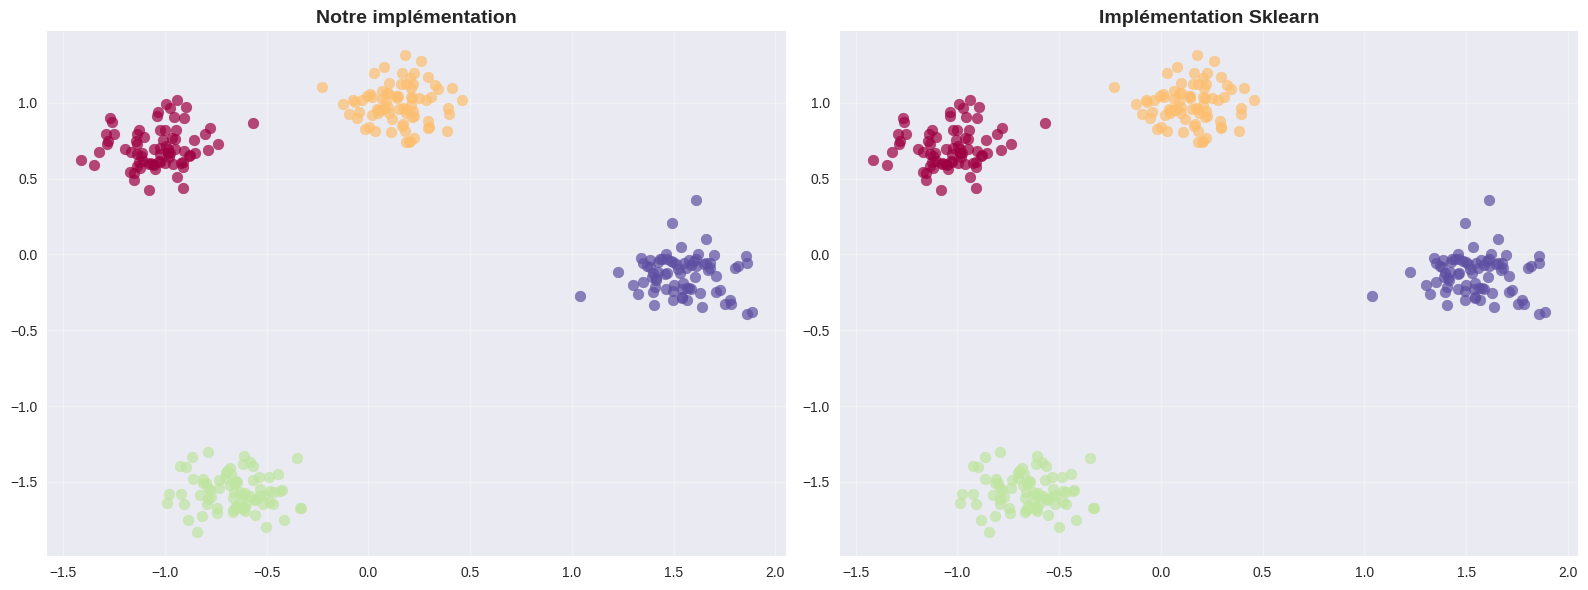


4. TEST SUR DIFFÉRENTS TYPES DE DATASETS
---------------------------------------------

Dataset: BLOBS
------------------------------
ANALYSE DES CLUSTERS
Nombre de clusters trouvés: 4
Nombre de points de bruit: 0
Total de points: 300

Taille de chaque cluster:
  Cluster 0: 75 points (25.0%)
  Cluster 1: 75 points (25.0%)
  Cluster 2: 75 points (25.0%)
  Cluster 3: 75 points (25.0%)


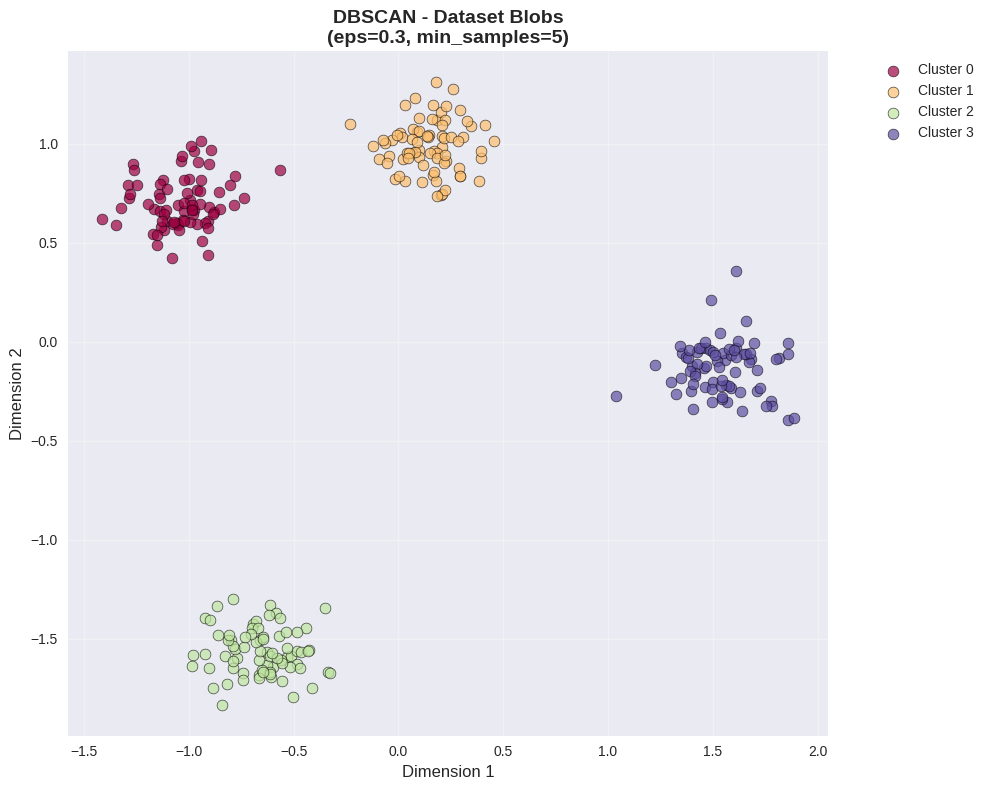


Dataset: CIRCLES
------------------------------
ANALYSE DES CLUSTERS
Nombre de clusters trouvés: 4
Nombre de points de bruit: 7
Total de points: 300

Taille de chaque cluster:
  Cluster 0: 225 points (75.0%)
  Cluster 1: 41 points (13.7%)
  Cluster 2: 8 points (2.7%)
  Cluster 3: 19 points (6.3%)


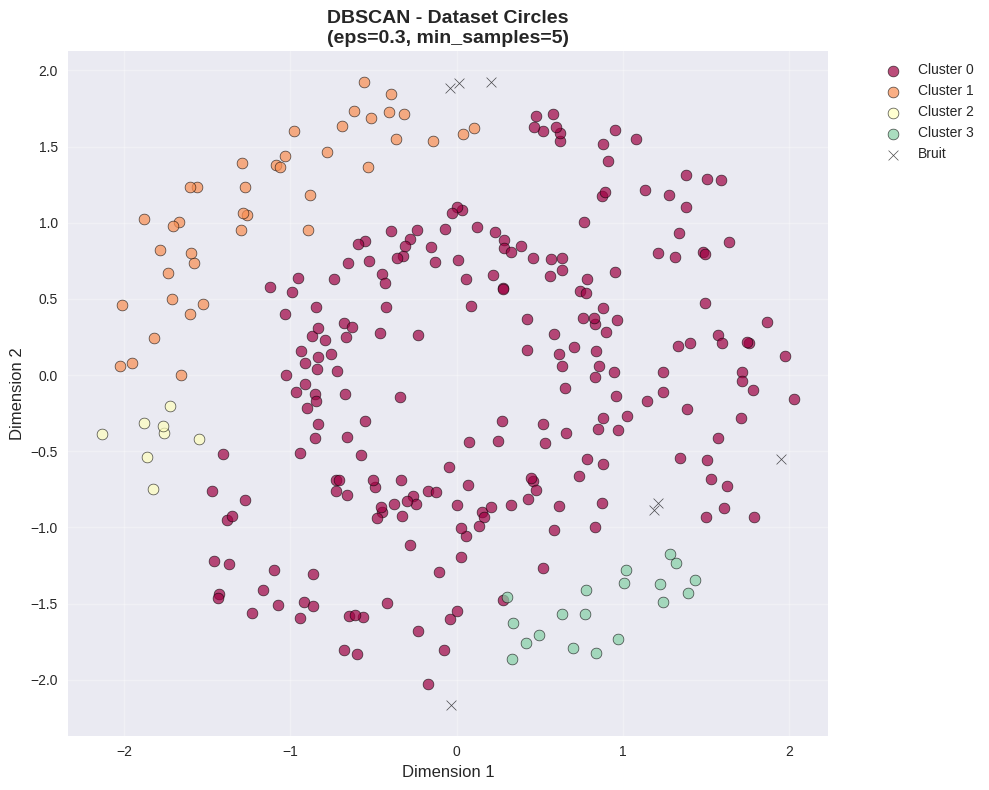


Dataset: MOONS
------------------------------
ANALYSE DES CLUSTERS
Nombre de clusters trouvés: 2
Nombre de points de bruit: 2
Total de points: 300

Taille de chaque cluster:
  Cluster 0: 149 points (49.7%)
  Cluster 1: 149 points (49.7%)


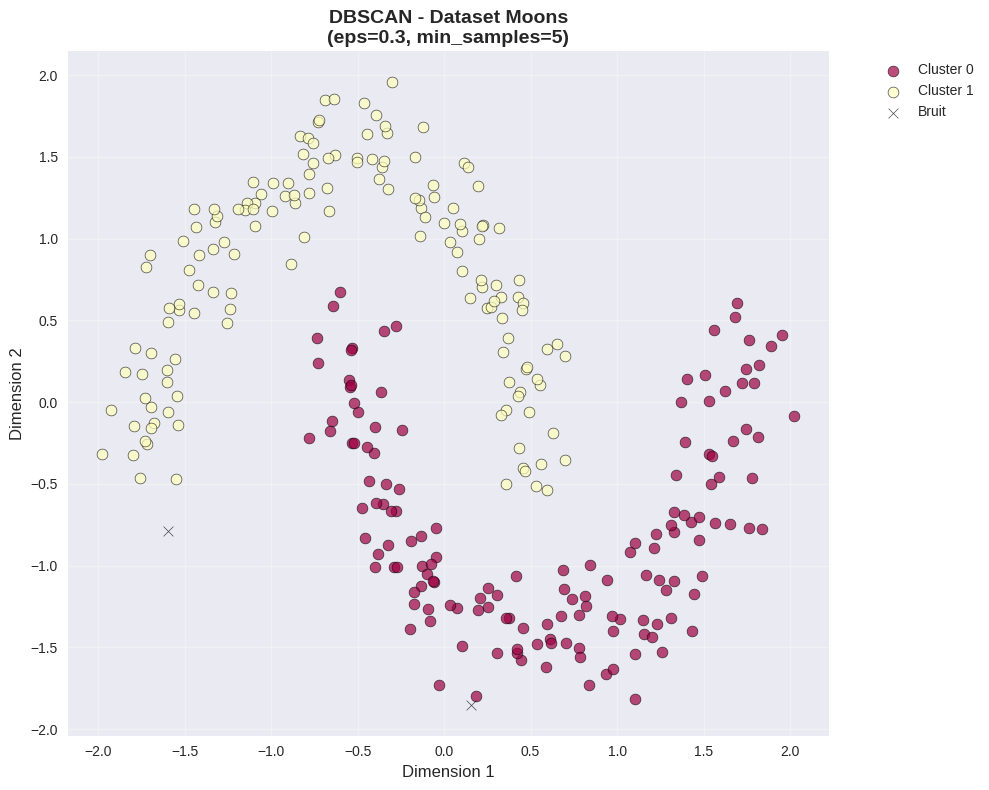


Dataset: NOISY
------------------------------
ANALYSE DES CLUSTERS
Nombre de clusters trouvés: 3
Nombre de points de bruit: 22
Total de points: 330

Taille de chaque cluster:
  Cluster 0: 107 points (32.4%)
  Cluster 1: 107 points (32.4%)
  Cluster 2: 94 points (28.5%)


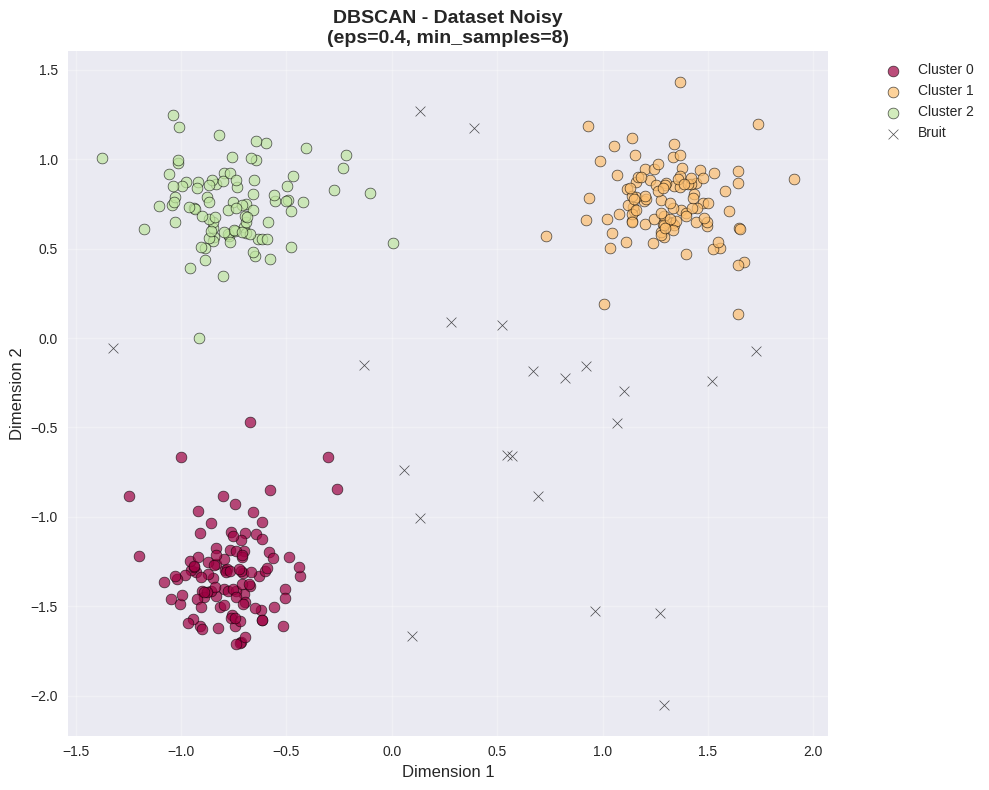


5. ANALYSE DE SENSIBILITÉ DES PARAMÈTRES
---------------------------------------------
Test de différentes combinaisons de paramètres...


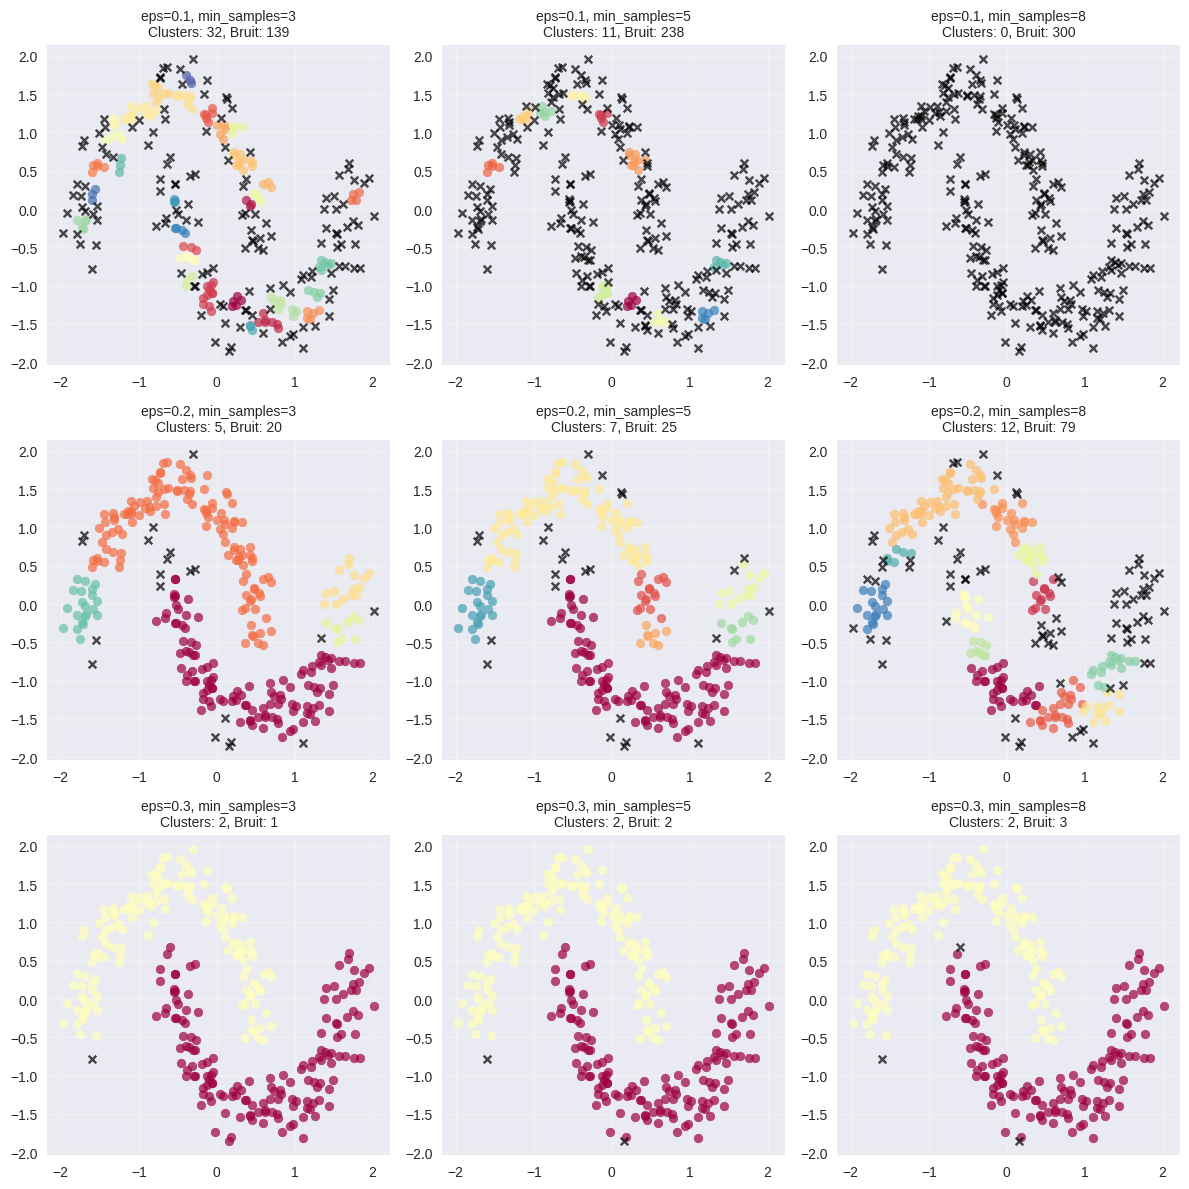


DÉMONSTRATION TERMINÉE
L'implémentation DBSCAN est fonctionnelle et a été testée avec succès!


In [18]:

# ============================================================================
# EXÉCUTION DU CODE
# ============================================================================

if __name__ == "__main__":
    # Choisir le type de démonstration
    print("Choisissez le type de démonstration:")
    print("1. Exemple simple")
    print("2. Démonstration complète")

    # Pour cette exécution automatique, on fait l'exemple simple
    print("\nExécution de l'exemple simple...\n")
    X, labels = simple_example()

    print("\nPour une démonstration complète, décommentez la ligne suivante:")
    print("# main_demonstration()")

    # Décommentez la ligne suivante pour la démonstration complète
    main_demonstration()


In [ ]:
# ============================================================================
# NOTES ET EXPLICATIONS ADDITIONNELLES
# ============================================================================

"""
EXPLICATION DÉTAILLÉE DE L'ALGORITHME:

1. INITIALISATION:
   - Tous les points sont marqués comme non visités
   - Les étiquettes sont initialisées à -1 (non assigné)
   - Un compteur de cluster est initialisé à 0

2. PARCOURS DES POINTS:
   - Pour chaque point non visité:
     a) Marquer le point comme visité
     b) Trouver tous ses voisins dans le rayon epsilon
     c) Si le nombre de voisins < min_samples: marquer comme bruit
     d) Sinon: créer un nouveau cluster et l'étendre

3. EXTENSION DU CLUSTER:
   - Utiliser une file d'attente pour parcourir tous les points densité-connectés
   - Pour chaque point dans la file:
     a) S'il n'est pas visité: le marquer et trouver ses voisins
     b) S'il a suffisamment de voisins: ajouter ses voisins à la file
     c) S'il n'appartient à aucun cluster: l'assigner au cluster actuel

4. TYPES DE POINTS:
   - Core point: A au moins min_samples voisins dans le rayon epsilon
   - Border point: N'est pas core mais dans le voisinage d'un core point
   - Noise point: Ni core ni border

5. COMPLEXITÉ:
   - Temporelle: O(n²) dans le pire cas, O(n log n) avec des structures optimisées
   - Spatiale: O(n) pour stocker les étiquettes et les états

6. AVANTAGES DE CETTE IMPLÉMENTATION:
   - Code clair et commenté pour comprendre l'algorithme
   - Gestion explicite des différents types de points
   - Utilisation d'une file d'attente pour l'extension efficace des clusters
   - Fonctions de visualisation et d'analyse intégrées

7. PARAMÈTRES CRITIQUES:
   - epsilon: Trop petit → trop de bruit, trop grand → fusion de clusters
   - min_samples: Généralement >= dimension + 1, plus élevé = plus conservateur
"""